# LSTM Modeling
Use a LSTM model.
Each group of (field, type, year_plant), where year_plant = harvest_year - age, is considered a sequence.

In [45]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [46]:
import pandas as pd
import numpy as np
import os 

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from kdd_utils import addFieldDataFtrs, addSoilFtrs, cvPerYear, load_model_ignoring, save_model_ignoring

sns.set(style="whitegrid")

In [47]:
from fastai.structured import *
from fastai.column_data import *
from fastai.column_seq_data import *

## Train and test datasets

Basic data containing palm tree information

In [48]:
path = '../input/'

# Train data.
df_all = pd.read_csv(os.path.join(path, 'all_clean.csv'))

print('Shape:', df_all.shape)

Shape: (9353, 8)


## Field and Soil Features

These files hold atmospheric data from January 2002 to December 2017, and can be used to estimate the weather conditions during the development of the plant. Notice that weather does influence the production. Using only a single month prior to harvest is probably too little data. Participants should decide how far back in the past they want to look when training models.



In [49]:
df_all_ftrs = addFieldDataFtrs(df_all, shiftFtrs=None)
df_all_ftrs = addSoilFtrs(df_all_ftrs)
print(list(df_all_ftrs.columns))

['index', 'Unnamed: 0', 'Id', 'age', 'field', 'harvest_month', 'harvest_year', 'production', 'type', 'month', 'year', 'temperature', 'dewpoint', 'windspeed', 'Soilwater_L1', 'Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4', 'Precipitation', 'BDRICM_BDRICM_M', 'BDRLOG_BDRLOG_M', 'BDTICM_BDTICM_M', 'BLDFIE_sl1', 'BLDFIE_sl2', 'BLDFIE_sl3', 'BLDFIE_sl4', 'BLDFIE_sl5', 'BLDFIE_sl6', 'BLDFIE_sl7', 'CECSOL_sl1', 'CECSOL_sl2', 'CECSOL_sl3', 'CECSOL_sl4', 'CECSOL_sl5', 'CECSOL_sl6', 'CECSOL_sl7', 'CLYPPT_sl1', 'CLYPPT_sl2', 'CLYPPT_sl3', 'CLYPPT_sl4', 'CLYPPT_sl5', 'CLYPPT_sl6', 'CLYPPT_sl7', 'CRFVOL_sl1', 'CRFVOL_sl2', 'CRFVOL_sl3', 'CRFVOL_sl4', 'CRFVOL_sl5', 'CRFVOL_sl6', 'CRFVOL_sl7', 'OCSTHA_sd1', 'OCSTHA_sd2', 'OCSTHA_sd3', 'OCSTHA_sd4', 'OCSTHA_sd5', 'OCSTHA_sd6', 'ORCDRC_sl1', 'ORCDRC_sl2', 'ORCDRC_sl3', 'ORCDRC_sl4', 'ORCDRC_sl5', 'ORCDRC_sl6', 'ORCDRC_sl7', 'PHIHOX_sl1', 'PHIHOX_sl2', 'PHIHOX_sl3', 'PHIHOX_sl4', 'PHIHOX_sl5', 'PHIHOX_sl6', 'PHIHOX_sl7', 'PHIKCL_sl1', 'PHIKCL_sl2', 'PHI

In [50]:
df_all_ftrs.head()

,index,Unnamed: 0,Id,age,field,harvest_month,harvest_year,production,type,month,...,SLTPPT_sl5,SLTPPT_sl6,SLTPPT_sl7,SNDPPT_sl1,SNDPPT_sl2,SNDPPT_sl3,SNDPPT_sl4,SNDPPT_sl5,SNDPPT_sl6,SNDPPT_sl7
0,0,0,0,19,0,1,2004,0.064071,5,1,...,22,22,23,44,45,44,39,38,37,36
1,1,1532,1532,13,0,1,2004,0.283228,2,1,...,22,22,23,44,45,44,39,38,37,36
2,2,4204,4204,4,0,1,2004,0.106263,5,1,...,22,22,23,44,45,44,39,38,37,36
3,3,1,1,19,0,2,2004,0.047658,5,2,...,22,22,23,44,45,44,39,38,37,36
4,4,1533,1533,13,0,2,2004,0.182068,2,2,...,22,22,23,44,45,44,39,38,37,36


In [51]:
# Categorical features.
cat_ftrs = ['field', 'age', 'type', 'harvest_month']
# Continuous features.
contin_ftrs = [f for f in df_all_ftrs.columns if f not in (['production', 'Id', 'index'] + cat_ftrs)]
print(contin_ftrs)

['Unnamed: 0', 'harvest_year', 'month', 'year', 'temperature', 'dewpoint', 'windspeed', 'Soilwater_L1', 'Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4', 'Precipitation', 'BDRICM_BDRICM_M', 'BDRLOG_BDRLOG_M', 'BDTICM_BDTICM_M', 'BLDFIE_sl1', 'BLDFIE_sl2', 'BLDFIE_sl3', 'BLDFIE_sl4', 'BLDFIE_sl5', 'BLDFIE_sl6', 'BLDFIE_sl7', 'CECSOL_sl1', 'CECSOL_sl2', 'CECSOL_sl3', 'CECSOL_sl4', 'CECSOL_sl5', 'CECSOL_sl6', 'CECSOL_sl7', 'CLYPPT_sl1', 'CLYPPT_sl2', 'CLYPPT_sl3', 'CLYPPT_sl4', 'CLYPPT_sl5', 'CLYPPT_sl6', 'CLYPPT_sl7', 'CRFVOL_sl1', 'CRFVOL_sl2', 'CRFVOL_sl3', 'CRFVOL_sl4', 'CRFVOL_sl5', 'CRFVOL_sl6', 'CRFVOL_sl7', 'OCSTHA_sd1', 'OCSTHA_sd2', 'OCSTHA_sd3', 'OCSTHA_sd4', 'OCSTHA_sd5', 'OCSTHA_sd6', 'ORCDRC_sl1', 'ORCDRC_sl2', 'ORCDRC_sl3', 'ORCDRC_sl4', 'ORCDRC_sl5', 'ORCDRC_sl6', 'ORCDRC_sl7', 'PHIHOX_sl1', 'PHIHOX_sl2', 'PHIHOX_sl3', 'PHIHOX_sl4', 'PHIHOX_sl5', 'PHIHOX_sl6', 'PHIHOX_sl7', 'PHIKCL_sl1', 'PHIKCL_sl2', 'PHIKCL_sl3', 'PHIKCL_sl4', 'PHIKCL_sl5', 'PHIKCL_sl6', 'PHIKCL_sl7', 'SLT

In [52]:
# Remove unused features.
df_all_ftrs = df_all_ftrs[cat_ftrs + contin_ftrs + ['production', 'Id']]
df_all_ftrs.head(2)

,field,age,type,harvest_month,Unnamed: 0,harvest_year,month,year,temperature,dewpoint,...,SLTPPT_sl7,SNDPPT_sl1,SNDPPT_sl2,SNDPPT_sl3,SNDPPT_sl4,SNDPPT_sl5,SNDPPT_sl6,SNDPPT_sl7,production,Id
0,0,19,5,1,0,2004,1,2004,26.132,24.661,...,23,44,45,44,39,38,37,36,0.064071,0
1,0,13,2,1,1532,2004,1,2004,26.132,24.661,...,23,44,45,44,39,38,37,36,0.283228,1532


In [53]:
val_year = 2011
test_year = 2012

train_mask = (df_all_ftrs.harvest_year < val_year)
val_mask = ((df_all_ftrs.harvest_year >= val_year) & (df_all_ftrs.harvest_year < test_year))
test_mask = (df_all_ftrs.harvest_year >= test_year)

df_train = df_all_ftrs[train_mask]
df_val = df_all_ftrs[val_mask]
df_test = df_all_ftrs[test_mask]

In [54]:
def getSeqs(df):
    df = df.reset_index(drop=True)
    df['year_plant'] = df.harvest_year - df.age
    seqs_lim = [0]
    row = df.iloc[0]
    vals = (row.field, row.type, row.year_plant)
    for i, row in df.iterrows():
        if (row.field, row.type, row.year_plant) != vals:
            seqs_lim.append(i)
            vals = (row.field, row.type, row.year_plant)
    return seqs_lim + [len(df)]

def getSeqsPerYear(df):
    df = df.reset_index(drop=True)
    seqs_lim = [0]
    row = df.iloc[0]
    vals = (row.field, row.type, row.harvest_year)
    for i, row in df.iterrows():
        if (row.field, row.type, row.harvest_year) != vals:
            seqs_lim.append(i)
            vals = (row.field, row.type, row.harvest_year)
    return seqs_lim + [len(df)]

# Compute list of sequence limits.
seqs_train = getSeqsPerYear(df_train)
seqs_val = getSeqsPerYear(df_val)
seqs_test = getSeqsPerYear(df_test)

In [55]:
def convType(df, cat_ftrs, contin_ftrs):
    # Inform pandas which features are categorical ...
    for v in cat_ftrs:
        df.loc[:,v] = df[v].astype('category').cat.as_ordered()
    # ... and which are continuous.
    for v in contin_ftrs:
        df.loc[:,v] = df[v].astype('float32')

for df in [df_train, df_val, df_test, df_all_ftrs]:
    convType(df, cat_ftrs, contin_ftrs)

/home/eraldo/miniconda2/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [56]:
# Compute list of embedding sizes.
cat_sz = [(c, len(df_all_ftrs[c].cat.categories) + 1) for c in cat_ftrs]
print(cat_sz)
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
print(emb_szs)

[('field', 29), ('age', 29), ('type', 10), ('harvest_month', 13)]
[(29, 15), (29, 15), (10, 5), (13, 7)]


In [57]:
df_train, y_train, nas, mapper = proc_df(df_train, y_fld='production', do_scale=True, 
                                         skip_flds=['Id'])

df_val, y_val, nas, mapper = proc_df(df_val, y_fld='production', do_scale=True, 
                                     mapper=mapper, na_dict=nas, skip_flds=['Id'])

test_ids = df_test.Id

df_test, _, nas, mapper = proc_df(df_test, y_fld='production', do_scale=True, 
                                  mapper=mapper, na_dict=nas, skip_flds=['Id'])

n_cont = len(df_train.columns) - len(cat_ftrs)

In [58]:
md = ColumnarSeqModelData.from_data_frames(path, # path for data saving
                                           seqs_train, # limits of training sequences
                                           df_train, # training set
                                           y_train, # output variable for the training set
                                           seqs_val, # limits of validation sequences
                                           df_val, # validation set
                                           y_val, # output variable for the validation set
                                           cat_flds=cat_ftrs, # categorical features
                                           is_reg=True, # not regression
                                           is_multi=False, # multi-label problem
                                           test_seqs_lim=seqs_test, # limits of test sequences
                                           test_df=df_test) # test set

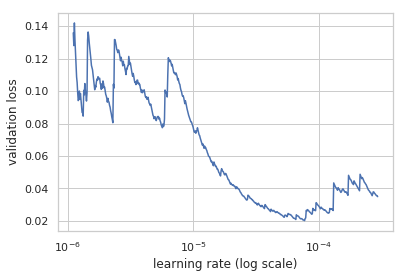

In [59]:
# dropout rate
dr = 0.01

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": n_cont, # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [300], # sizes of fully-connected layers
    "drops": [dr], # dropout probabilities after each FC layer
    "lstm_hidden_size": 100, # size of the LSTM hidden states
    "lstm_num_layers": 1, # number of LSTM layers
    "lstm_dropout": dr, # LSTM dropout
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

m.lr_find(start_lr=1e-6)
m.sched.plot()

In [60]:
# dropout rate
dr = 0.1

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": n_cont, # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [300], # sizes of fully-connected layers
    "drops": [dr], # dropout probabilities after each FC layer
    "lstm_hidden_size": 100, # size of the LSTM hidden states
    "lstm_num_layers": 1, # number of LSTM layers
    "lstm_dropout": dr, # LSTM dropout
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

def mae(y_true, y_pred):
    return metrics.mean_absolute_error(y_true.squeeze(), y_pred.squeeze())

lr=1e-5
m.fit(lr, n_cycle=10, metrics=[mae])

epoch      trn_loss   val_loss   mae                             
    0      0.026687   0.024382   0.117014  
    1      0.019223   0.020301   0.107471                        
    2      0.018388   0.018496   0.105048                        
    3      0.011571   0.017536   0.099403                         
    4      0.017289   0.016937   0.099919                         
    5      0.009727   0.016697   0.095821                         
    6      0.010896   0.016707   0.098547                        
    7      0.011113   0.015983   0.095201                        
    8      0.012479   0.016898   0.099334                         
    9      0.00852    0.016263   0.093963                         


[array([0.01626]), 0.09396300467445327]

In [62]:
# dropout rate
dr = 0.0

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": n_cont, # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [300], # sizes of fully-connected layers
    "drops": [dr], # dropout probabilities after each FC layer
    "lstm_hidden_size": 100, # size of the LSTM hidden states
    "lstm_num_layers": 1, # number of LSTM layers
    "lstm_dropout": dr, # LSTM dropout
    "use_bn": False, # batch normalization
    "y_range": [0.0, 1.0]
}

m = md.get_learner(**learner_params)

def mae(y_true, y_pred):
    return metrics.mean_absolute_error(y_true.squeeze(), y_pred.squeeze())

lr=1e-5
m.fit(lr, n_cycle=10, metrics=[mae])

epoch      trn_loss   val_loss   mae                             
    0      0.018076   0.02113    0.112031  
    1      0.012362   0.018631   0.098935                        
    2      0.015154   0.01733    0.095051                         
    3      0.018112   0.016571   0.095786                        
    4      0.020348   0.016236   0.094763                         
    5      0.009856   0.016101   0.093957                         
    6      0.015139   0.016011   0.094515                         
    7      0.017217   0.01587    0.093579                         
    8      0.020293   0.015733   0.095006                         
    9      0.010519   0.015712   0.093517                         


[array([0.01571]), 0.09351728804291708]

In [71]:
# dropout rate
dr = 0.5

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": n_cont, # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [300, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "lstm_hidden_size": 100, # size of the LSTM hidden states
    "lstm_num_layers": 2, # number of LSTM layers
    "lstm_dropout": dr, # LSTM dropout
    "use_bn": False, # batch normalization
    "y_range": [0.0, 1.0]
}

m = md.get_learner(**learner_params)

def mae(y_true, y_pred):
    return metrics.mean_absolute_error(y_true.squeeze(), y_pred.squeeze())

lr=1e-4
m.fit(lr, n_cycle=10, metrics=[mae])

epoch      trn_loss   val_loss   mae                             
    0      0.017406   0.023324   0.102905  
    1      0.014457   0.020847   0.097834                        
    2      0.024014   0.018886   0.094977                         
    3      0.010158   0.020152   0.097686                         
    4      0.021012   0.018028   0.094876                        
    5      0.011536   0.019061   0.097404                         
    6      0.021793   0.018248   0.096158                         
    7      0.012375   0.018688   0.097191                         
    8      0.009725   0.018965   0.097095                         
    9      0.015222   0.017122   0.094482                         


[array([0.01712]), 0.09448212982254772]

## Submission file

In [21]:
# dropout rate
dr = 0.3

learner_params = {
    "emb_szs": emb_szs, # embedding sizes
    "n_cont": len(df.columns) - len(cat_ftrs), # num continuous inputs
    "emb_drop": dr, # embeddings dropout probability
    "out_sz": 1, # output size
    "szs": [300, 100], # sizes of fully-connected layers
    "drops": [dr, dr], # dropout probabilities after each FC layer
    "use_bn": False # batch normalization
}

m = md.get_learner(**learner_params)

m.load('finetune-all-clean-trn011')

In [35]:
from datetime import datetime

# Make prediction.
pred = m.predict(is_test=True).squeeze()

now = datetime.now().strftime('%Y-%m-%d-%H-%M-%S-%f')

submission_file  = '../submissions/{}.submission.csv'.format(now)
model_file       = '../submissions/{}.model'.format(now)

# Create a submission file.
with open(submission_file, 'w') as f:
    f.write("Id,production\n")
    for _id, _pred in zip(test_ids.values, pred):
        f.write("{},{}\n".format(_id, min(1.0, max(0.0, _pred))))

# Save model.
save_model(m.model, model_file)